**Background & Context**


The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

You need to identify the best possible model that will give the required performance

**Objective**


Explore and visualize the dataset.

Build a classification model to predict if the customer is going to churn or not

Optimize the model using appropriate techniques

Generate a set of insights and recommendations that will help the bank

In [35]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# To tune model, get different metric scores and split data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To impute missing values
from sklearn.impute import KNNImputer

# To bin continuous data into intervals
from sklearn.preprocessing import KBinsDiscretizer

# To build a logistic regression model
from sklearn.linear_model import LogisticRegression

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


ModuleNotFoundError: No module named 'imblearn'

In [37]:
!pip install nb-black


  Preparing metadata (setup.py) ... done
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5297 sha256=c54bca2024e5b598f86232536cb0c2d72403af7d265030767be8633f95d12427
  Stored in directory: /home/zubair/.cache/pip/wheels/25/9d/fc/6312e3d8a66c164cc7f9d80bc66cc25de03a362a30b9f84aa3
Successfully built nb-black

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [38]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [39]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [40]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [41]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [42]:
# to work with dataframes
import pandas as pd
import numpy as np

# to split data into train and test
from sklearn.model_selection import train_test_split

# to build logistic regression model
from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [43]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [45]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

In [46]:
# bc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BankChurners.csv')
bc = pd.read_csv('./BankChurners.csv')

In [47]:
# checking shape of the data
print(f"There are {bc.shape[0]} rows and {bc.shape[1]} columns.")

There are 10127 rows and 21 columns.


In [133]:
# let's create a copy of the data
df = bc.copy()

<IPython.core.display.Javascript object>

In [134]:
# let's view the first 5 rows of the data
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


<IPython.core.display.Javascript object>

In [135]:
# let's view the last 5 rows of the data
df.tail()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,NaN,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,NaN,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189


<IPython.core.display.Javascript object>

In [136]:
# let's check the data types of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

<IPython.core.display.Javascript object>

15 variables are of numerical type, while 6 are object/categorical type.

Education_Level and Marital_Status have several missing values (8608 non-null and 9378 non-null values respectively, instead of 10127 non-null values).

In [137]:
# let's check for duplicate values in the data
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

There are no duplicate values in the dataset.

In [138]:
# let's check for missing values in the data
round(df.isnull().sum() / df.isnull().count() * 100, 2)

CLIENTNUM                    0.0
Attrition_Flag               0.0
Customer_Age                 0.0
Gender                       0.0
Dependent_count              0.0
Education_Level             15.0
Marital_Status               7.4
Income_Category              0.0
Card_Category                0.0
Months_on_book               0.0
Total_Relationship_Count     0.0
Months_Inactive_12_mon       0.0
Contacts_Count_12_mon        0.0
Credit_Limit                 0.0
Total_Revolving_Bal          0.0
Avg_Open_To_Buy              0.0
Total_Amt_Chng_Q4_Q1         0.0
Total_Trans_Amt              0.0
Total_Trans_Ct               0.0
Total_Ct_Chng_Q4_Q1          0.0
Avg_Utilization_Ratio        0.0
dtype: float64

<IPython.core.display.Javascript object>

Education_Level column has 15% of values missing.

Maritial_Status column has 7.4% of values missing.

We are going to impute the missing values for these columns after splitting the dat into train set, validation set, and test set.

In [139]:
# let's view the statistical summary of the numerical columns in the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


<IPython.core.display.Javascript object>

In [140]:
# list of all categorical variables
cat_col = df.columns

# printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(df[column].value_counts(normalize=True))
    print("-" * 50)

768805383    0.000099
711784908    0.000099
720133908    0.000099
803197833    0.000099
812222208    0.000099
               ...   
796903083    0.000099
716014983    0.000099
712521783    0.000099
780045708    0.000099
714337233    0.000099
Name: CLIENTNUM, Length: 10127, dtype: float64
--------------------------------------------------
Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64
--------------------------------------------------
44    0.049373
49    0.048879
46    0.048386
45    0.047991
47    0.047299
43    0.046707
48    0.046608
50    0.044633
42    0.042066
51    0.039301
53    0.038215
41    0.037425
52    0.037128
40    0.035647
39    0.032882
54    0.030315
38    0.029920
55    0.027550
56    0.025871
37    0.025674
57    0.022020
36    0.021823
35    0.018169
59    0.015503
58    0.015503
34    0.014417
33    0.012541
60    0.012541
32    0.010467
65    0.009973
61    0.009183
62    0.009183
31    0.008986
26    0.007702
30  

<IPython.core.display.Javascript object>

In [141]:
for i in cat_col:
    print("Unique values in", i, "are :")
    print(df[i].value_counts())
    print("*" * 50)

Unique values in CLIENTNUM are :
768805383    1
711784908    1
720133908    1
803197833    1
812222208    1
            ..
796903083    1
716014983    1
712521783    1
780045708    1
714337233    1
Name: CLIENTNUM, Length: 10127, dtype: int64
**************************************************
Unique values in Attrition_Flag are :
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Customer_Age are :
44    500
49    495
46    490
45    486
47    479
43    473
48    472
50    452
42    426
51    398
53    387
41    379
52    376
40    361
39    333
54    307
38    303
55    279
56    262
37    260
57    223
36    221
35    184
59    157
58    157
34    146
33    127
60    127
32    106
65    101
61     93
62     93
31     91
26     78
30     70
63     65
29     56
64     43
27     32
28     29
67      4
66      2
68      2
70      1
73      1
Name: Customer_Age, dtype: int64
***********

<IPython.core.display.Javascript object>

In [142]:
# checking the names of the columns in the data
print(df.columns)

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


<IPython.core.display.Javascript object>

In [143]:
## Converting the data type of categorical features to 'category'
cat_col = [
    "Attrition_Flag",
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
    "Dependent_count",
    "Months_Inactive_12_mon",
    "Total_Relationship_Count",
    "Contacts_Count_12_mon",
]
df[cat_col] = df[cat_col].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CLIENTNUM                 10127 non-null  int64   
 1   Attrition_Flag            10127 non-null  category
 2   Customer_Age              10127 non-null  int64   
 3   Gender                    10127 non-null  category
 4   Dependent_count           10127 non-null  category
 5   Education_Level           8608 non-null   category
 6   Marital_Status            9378 non-null   category
 7   Income_Category           10127 non-null  category
 8   Card_Category             10127 non-null  category
 9   Months_on_book            10127 non-null  int64   
 10  Total_Relationship_Count  10127 non-null  category
 11  Months_Inactive_12_mon    10127 non-null  category
 12  Contacts_Count_12_mon     10127 non-null  category
 13  Credit_Limit              10127 non-null  floa

<IPython.core.display.Javascript object>

In [144]:
for i in cat_col:
    print("Unique values in", i, "are :")
    print(df[i].value_counts())
    print("*" * 50)

Unique values in Attrition_Flag are :
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Gender are :
F    5358
M    4769
Name: Gender, dtype: int64
**************************************************
Unique values in Education_Level are :
Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
**************************************************
Unique values in Marital_Status are :
Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64
**************************************************
Unique values in Income_Category are :
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
**************************************************

<IPython.core.display.Javascript object>

DATA PRE-PROCESSING

In [145]:
# CLIENTNUM is unique for each candidate and might not add value to modeling
df.drop(["CLIENTNUM"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [146]:
# Create a copy of data to perform detailed EDA in the appendix section.
df = bc.copy()

<IPython.core.display.Javascript object>

We will do missing value imputation after splitting the data into train, test and validation to avoid data leakage

**UNIVARIATE ANALYSIS**



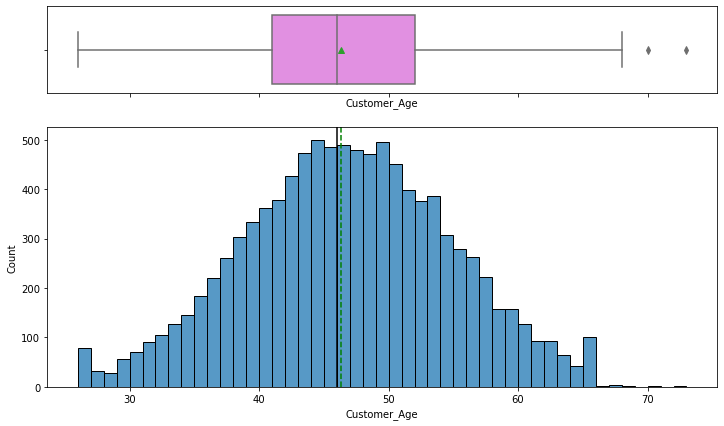

In [62]:
histogram_boxplot(df, "Customer_Age")

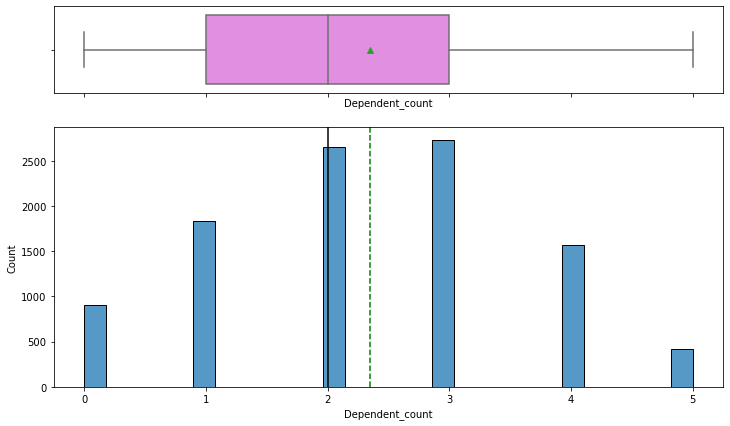

In [63]:
histogram_boxplot(df, "Dependent_count")

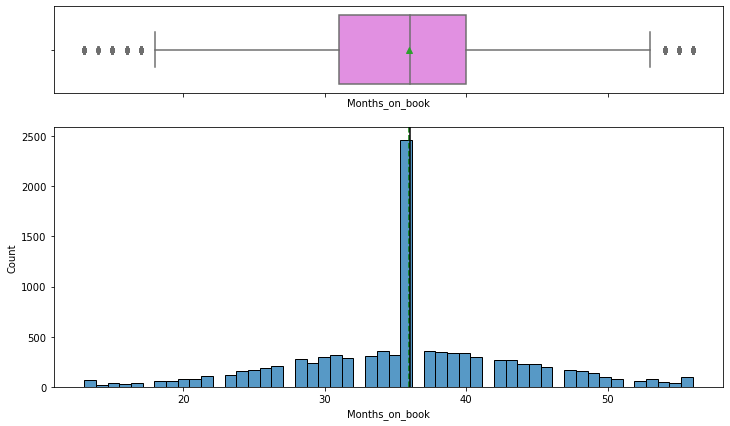

In [64]:
histogram_boxplot(df, "Months_on_book")

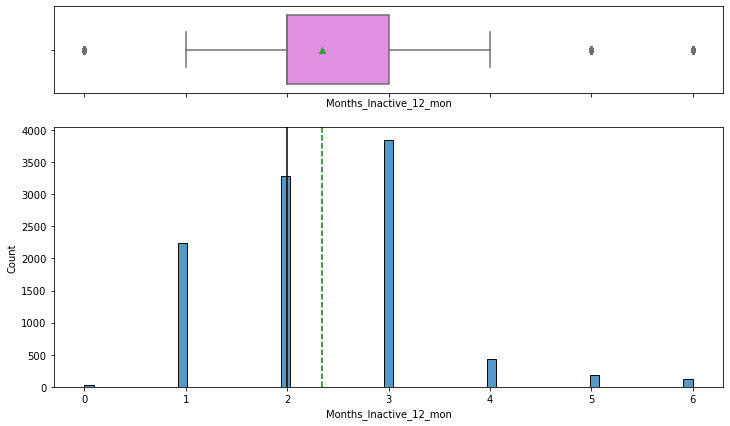

In [65]:
histogram_boxplot (df, "Months_Inactive_12_mon")

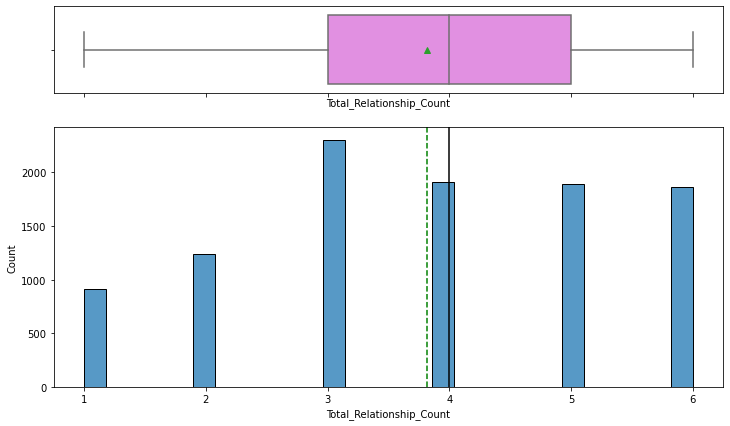

In [66]:
histogram_boxplot (df, "Total_Relationship_Count")

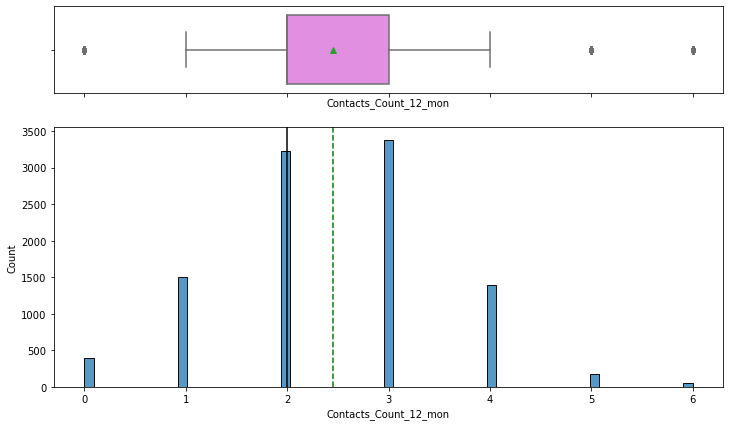

In [67]:
histogram_boxplot (df, "Contacts_Count_12_mon")

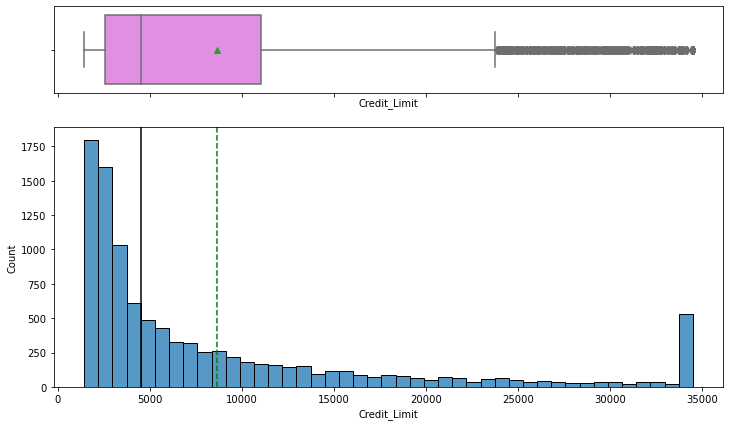

In [68]:
histogram_boxplot (df, "Credit_Limit")

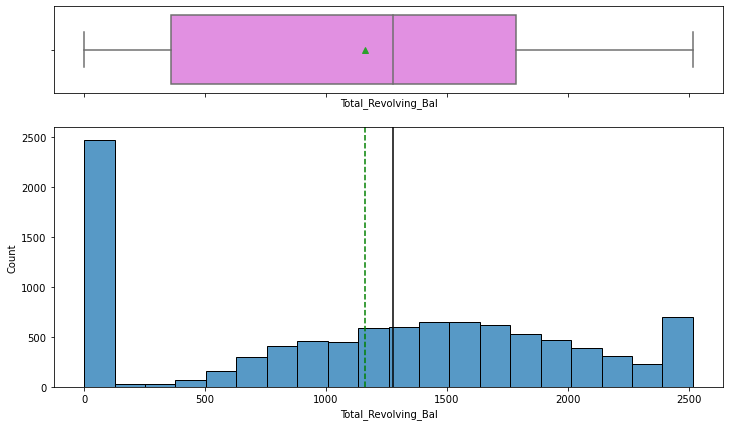

In [69]:
histogram_boxplot (df, "Total_Revolving_Bal")

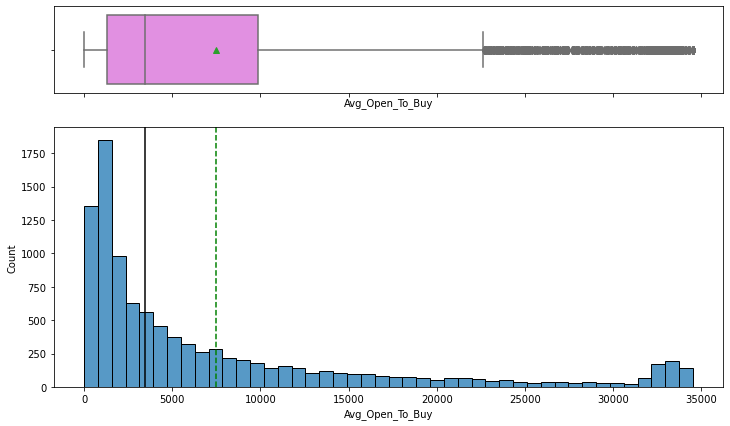

In [70]:
histogram_boxplot (df, "Avg_Open_To_Buy")

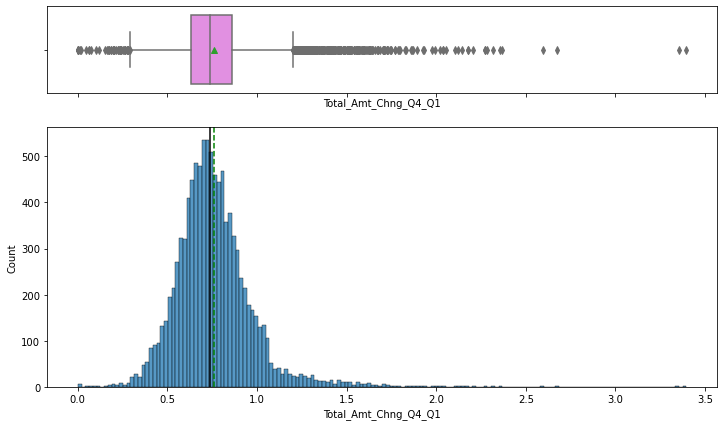

In [71]:
histogram_boxplot (df, "Total_Amt_Chng_Q4_Q1")

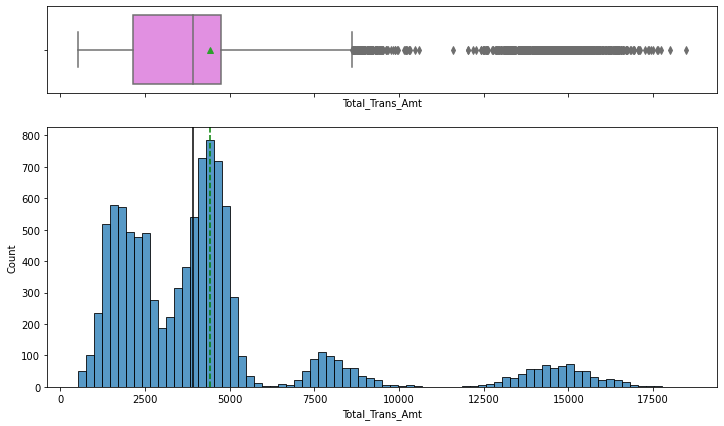

In [72]:
histogram_boxplot (df, "Total_Trans_Amt")

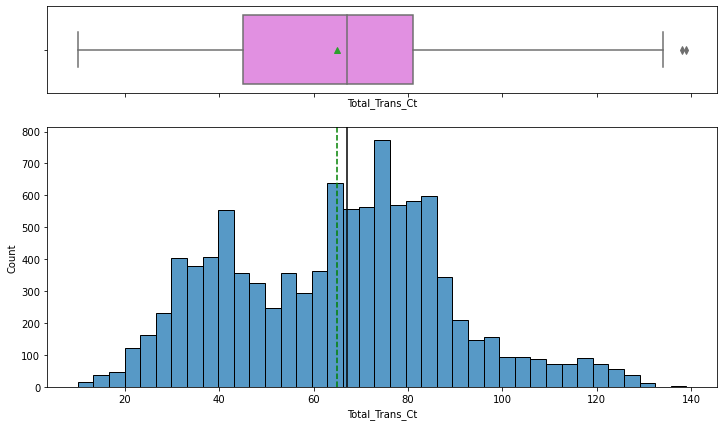

In [73]:
histogram_boxplot (df, "Total_Trans_Ct")

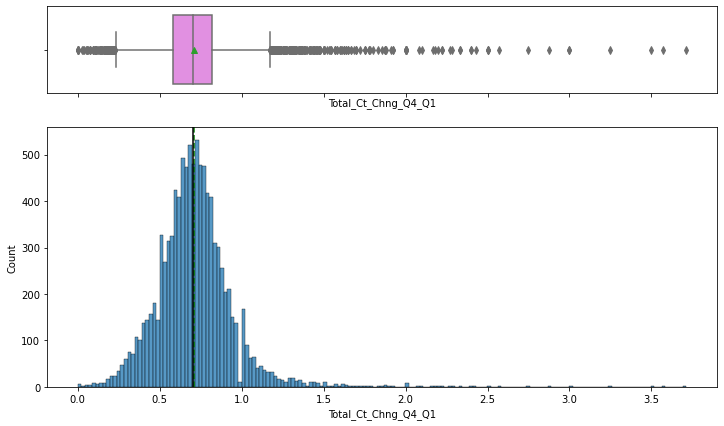

In [74]:
histogram_boxplot (df, "Total_Ct_Chng_Q4_Q1")

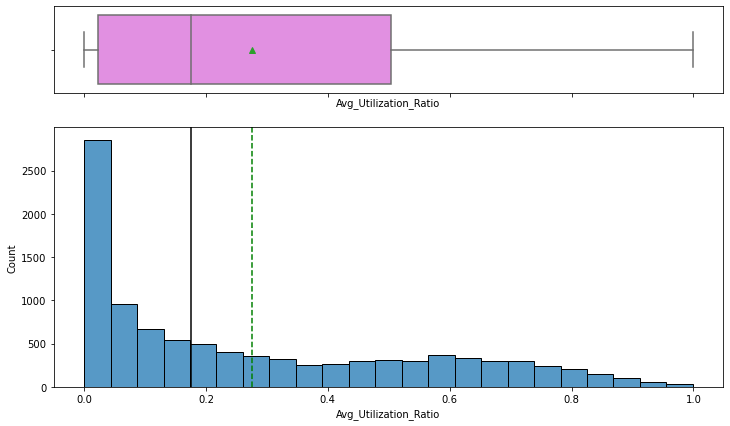

In [75]:
histogram_boxplot (df, "Avg_Utilization_Ratio")

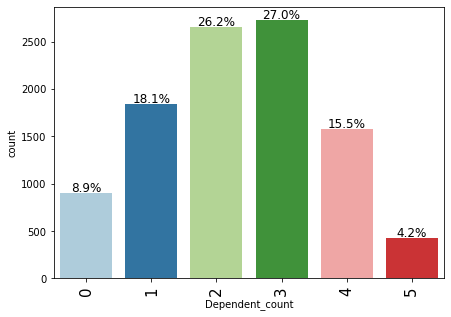

In [76]:
labeled_barplot(df, "Dependent_count", perc=True)

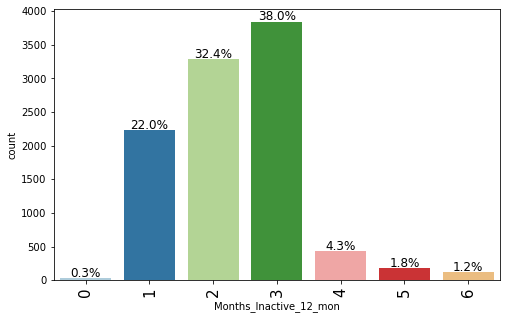

In [77]:
labeled_barplot(df, "Months_Inactive_12_mon", perc=True)

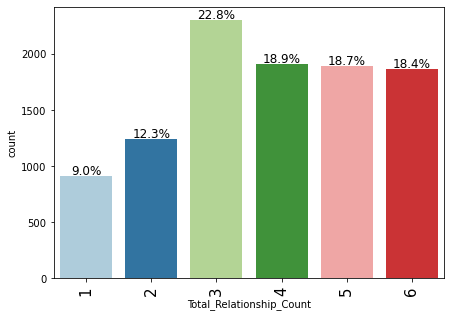

In [78]:
labeled_barplot(df, "Total_Relationship_Count", perc=True)

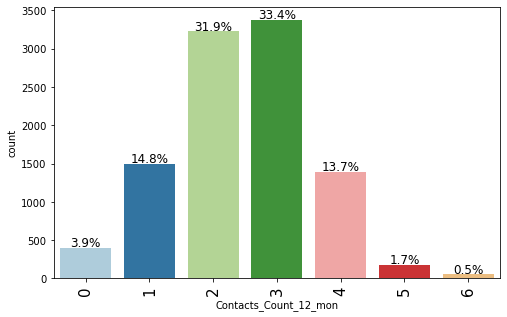

In [79]:
labeled_barplot(df, "Contacts_Count_12_mon", perc=True)

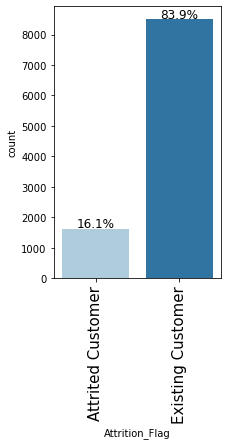

In [80]:
labeled_barplot(df, "Attrition_Flag", perc=True)

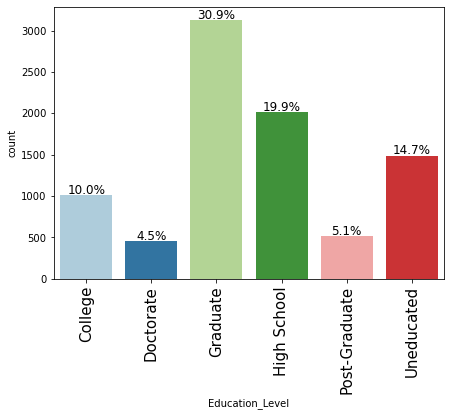

In [81]:
labeled_barplot(df, "Education_Level", perc=True)

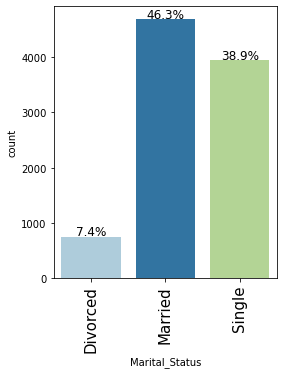

In [82]:
labeled_barplot(df, "Marital_Status", perc=True)

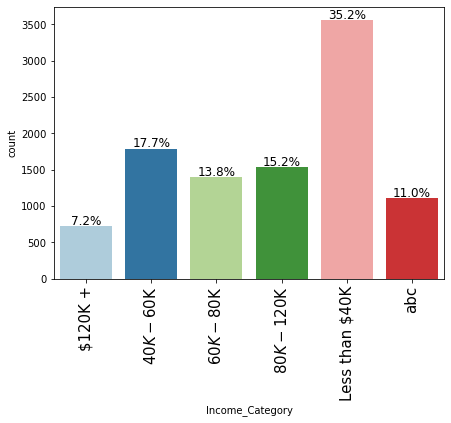

In [83]:
labeled_barplot(df, "Income_Category", perc=True)

In [1]:
labeled_barplot(df, "Card_Category", perc=True)

NameError: name 'labeled_barplot' is not defined

**BIVARIATE ANALYSIS**



In [2]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

NameError: name 'plt' is not defined

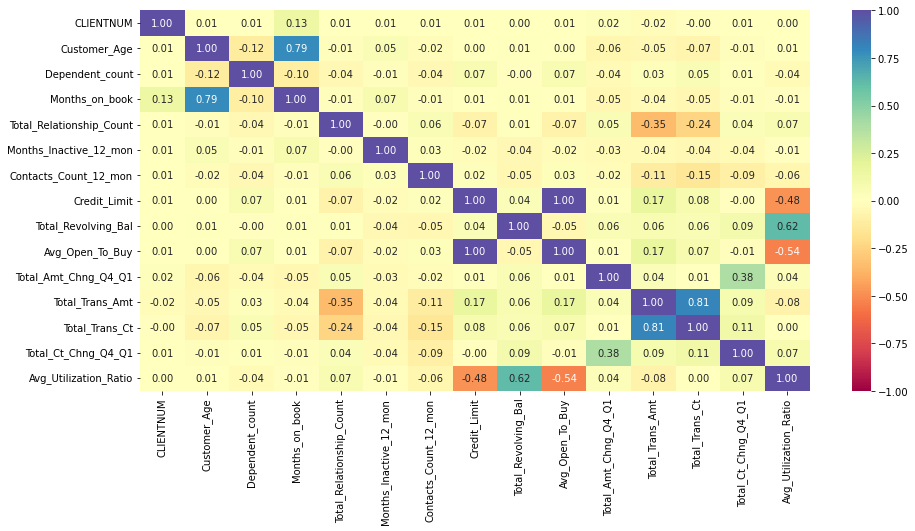

In [86]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
All                          1627               8500  10127
F                             930               4428   5358
M                             697               4072   4769
------------------------------------------------------------------------------------------------------------------------


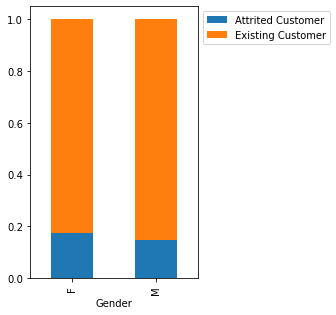

In [87]:
stacked_barplot(df, "Gender", "Attrition_Flag")

Females have slightly higher attrition rate than males but the difference is not remarkable.

Attrition_Flag   Attrited Customer  Existing Customer    All
Dependent_count                                             
All                           1627               8500  10127
3                              482               2250   2732
2                              417               2238   2655
1                              269               1569   1838
4                              260               1314   1574
0                              135                769    904
5                               64                360    424
------------------------------------------------------------------------------------------------------------------------


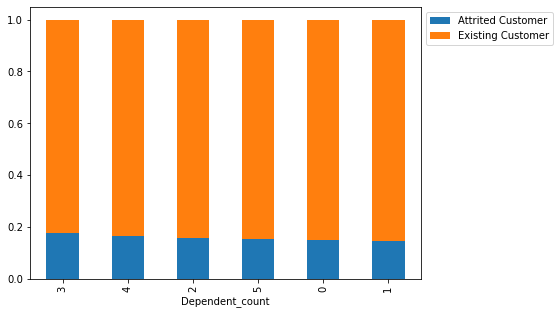

In [88]:
stacked_barplot(df, "Dependent_count", "Attrition_Flag")

No difference in attrition rate based on the count of dependents.

Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
All                           1371               7237  8608
Graduate                       487               2641  3128
High School                    306               1707  2013
Uneducated                     237               1250  1487
College                        154                859  1013
Doctorate                       95                356   451
Post-Graduate                   92                424   516
------------------------------------------------------------------------------------------------------------------------


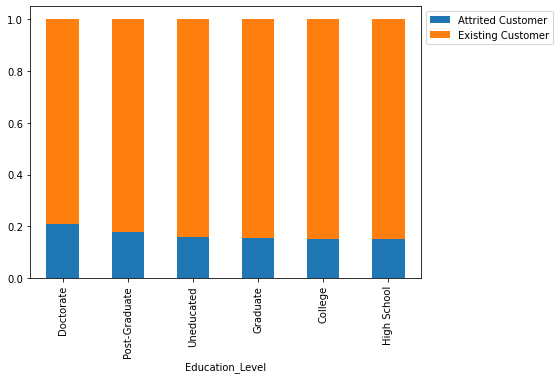

In [89]:
stacked_barplot(df, "Education_Level", "Attrition_Flag")

Attrition rate is slightly highar for those with doctorate degrees and is relatively lower for those with high school, college, graduate degrees, or uneducated customers.  But the difference is not remarkable.

Attrition_Flag  Attrited Customer  Existing Customer   All
Marital_Status                                            
All                          1498               7880  9378
Married                       709               3978  4687
Single                        668               3275  3943
Divorced                      121                627   748
------------------------------------------------------------------------------------------------------------------------


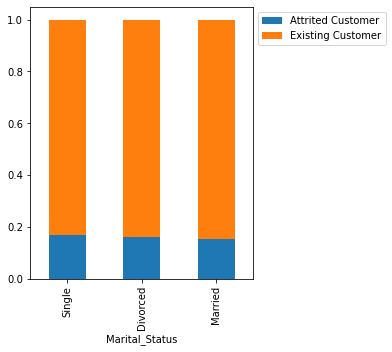

In [90]:
stacked_barplot(df, "Marital_Status", "Attrition_Flag")

No difference in attrition rates based on marital status.

Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
All                           1627               8500  10127
Less than $40K                 612               2949   3561
$40K - $60K                    271               1519   1790
$80K - $120K                   242               1293   1535
$60K - $80K                    189               1213   1402
abc                            187                925   1112
$120K +                        126                601    727
------------------------------------------------------------------------------------------------------------------------


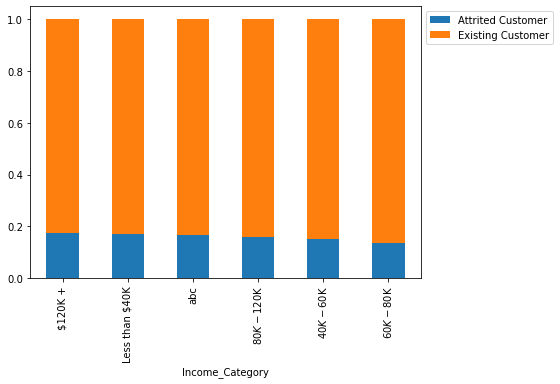

In [91]:
stacked_barplot(df, "Income_Category", "Attrition_Flag")

No major difference in attrition rates for customers from different income categories.

Attrition_Flag  Attrited Customer  Existing Customer    All
Card_Category                                              
All                          1627               8500  10127
Blue                         1519               7917   9436
Silver                         82                473    555
Gold                           21                 95    116
Platinum                        5                 15     20
------------------------------------------------------------------------------------------------------------------------


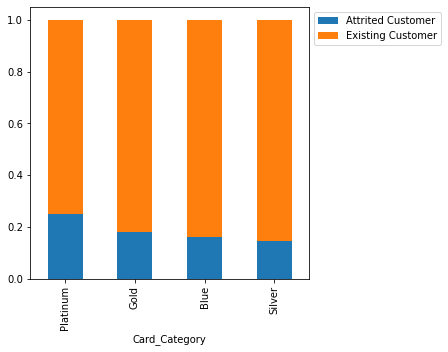

In [92]:
stacked_barplot(df, "Card_Category", "Attrition_Flag")

Attrition rate is a bit higher for those holding Platinum cards compared to other card types.

Attrition_Flag            Attrited Customer  Existing Customer    All
Total_Relationship_Count                                             
All                                    1627               8500  10127
3                                       400               1905   2305
2                                       346                897   1243
1                                       233                677    910
5                                       227               1664   1891
4                                       225               1687   1912
6                                       196               1670   1866
------------------------------------------------------------------------------------------------------------------------


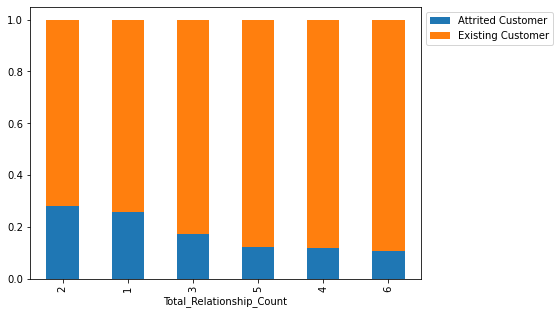

In [93]:
stacked_barplot(df, "Total_Relationship_Count", "Attrition_Flag")

This graph is very helpful!  The attrition rates are visibly a lot higher among those customers that hold lower total number of products.  Those who hold only 1-2 products have the highest attrition rates followed by those that hold 3.  Those who whold 4, 5, or 6 products have the lowest attrition rates and similar attrition rates.

Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
All                                  1627               8500  10127
3                                     826               3020   3846
2                                     505               2777   3282
4                                     130                305    435
1                                     100               2133   2233
5                                      32                146    178
6                                      19                105    124
0                                      15                 14     29
------------------------------------------------------------------------------------------------------------------------


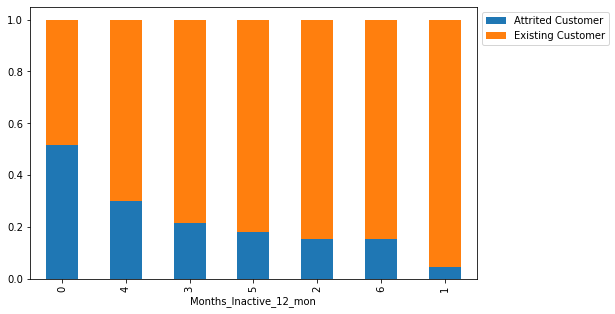

In [94]:
stacked_barplot(df, "Months_Inactive_12_mon", "Attrition_Flag")

This stacked barplot is somewhat bizarre.   Customers with only 1 month of inactivity have the Lowest attrition rate, which makes sense!  However, patients with zero month of inactivity have the highest attrition rate???! Customers with higher number of inactive months also have higher attrition rates, which makes sense.  However, what doesn't fit the pattern is the fact that those customers who are active at all times without any gap inactivity would have 50% attrition rate!  This needs to be looked into further.

Attrition_Flag         Attrited Customer  Existing Customer    All
Contacts_Count_12_mon                                             
All                                 1627               8500  10127
3                                    681               2699   3380
2                                    403               2824   3227
4                                    315               1077   1392
1                                    108               1391   1499
5                                     59                117    176
6                                     54                  0     54
0                                      7                392    399
------------------------------------------------------------------------------------------------------------------------


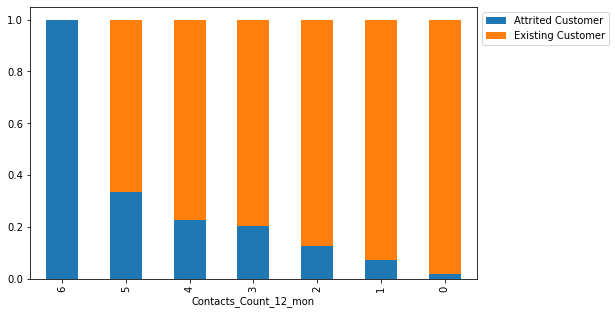

In [95]:
stacked_barplot(df, "Contacts_Count_12_mon", "Attrition_Flag")

There is a helpful patten here!  The higher tha count of contact between the customer and the bank in the last 12 months, the higher the attrition rate!  In fact, those customers with 6 counts of interaction with the bank had a 100% attrition rate while those with 5 counts of interaction with the bank had a 30-35% attrition rate!  Those with 2 interactions had 10% attrition rate!  Those with 0 interactions had attrition rates in low single digits based on the group.  There is a very solid pattern here.  Are the attrition rates higher because the customers are interacting with the bank way too often?  Or are their interactions suggestive of a deeper problem?  Are these interctions associated with poor service and complaints, triggering the calls?  Or are they associated with services that the customers wanted but were dissatisfied with later on due to poor experience with the service?  We are not sure if this is just association, coincidence, or cause/effect relationship.  If it's cause effect relationship, we don't know if more interacion is leading to higher attrition rate or that more interaction is simply a surrogate for an underlying deeper problem due to which customers are interacting more with the bank to have it resolved and then finally quit when they are not happy/satisfied with the service or with resolutions offered (or not offered!).

**SUMMARY OF EDA**

The dataset has 10127 rows and 21 columns.

15 variables are numerical, remaining 6 are object types.

2 columns have less than 10127 non-null values i.e. columns have missing values.

Data Cleaning

Drop "CLIENTNUM" as "CLIENTNUM" is unique for each candidate and might not add value to modeling.

Missing value imputation will be done after splitting the data.

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Approaching Categorical Features</h1><a id = "4" ></a>

Categorical variables/features are any feature type can be classified into two major
types:
*  Nominal
*  Ordinal

**Nominal variables** are variables that have two or more categories which do not
have any kind of order associated with them. For example, if gender is classified
into two groups, i.e. male and female, it can be considered as a nominal variable.

**Ordinal variables** on the other hand, have “levels” or categories with a particular
order associated with them. For example, an ordinal categorical variable can be a
feature with three different levels: low, medium and high. Order is important.

Ordinal variables in this data are :-

1. Income_Category
2. Card_Category
3. Education_Level

In this notebook i will seprately encode ordinal variables first

In [96]:
Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4,
    'Unknown'        : 5
}


Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
}


Attrition_Flag_map = {
    'Existing Customer' : 0,
    'Attrited Customer' : 1
}

Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
}


df.loc[:, 'Income_Category'] = df['Income_Category'].map(Income_Category_map)
df.loc[:, 'Card_Category'] = df['Card_Category'].map(Card_Category_map)
df.loc[:, 'Attrition_Flag'] = df['Attrition_Flag'].map(Attrition_Flag_map)
df.loc[:, 'Education_Level'] = df['Education_Level'].map(Education_Level_map)


**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.
![](https://ekababisong.org/assets/seminar_IEEE/LabelEncoder.png)  

We can do label Encoding From LabelEncoder of scikit-Learn but to do so first we have to impute missing values in data 

In [98]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()

cat_cols = [x for x in df.columns if df[x].dtype == 'object']

for c in cat_cols:
    df.loc[:, c] = lbe.fit_transform(df.loc[:, c])

In [99]:
df = df.sample(frac = 1).reset_index(drop = True) #To shuffle data

X = df.drop(['Attrition_Flag', 'CLIENTNUM'], axis = 1)
y = df.Attrition_Flag

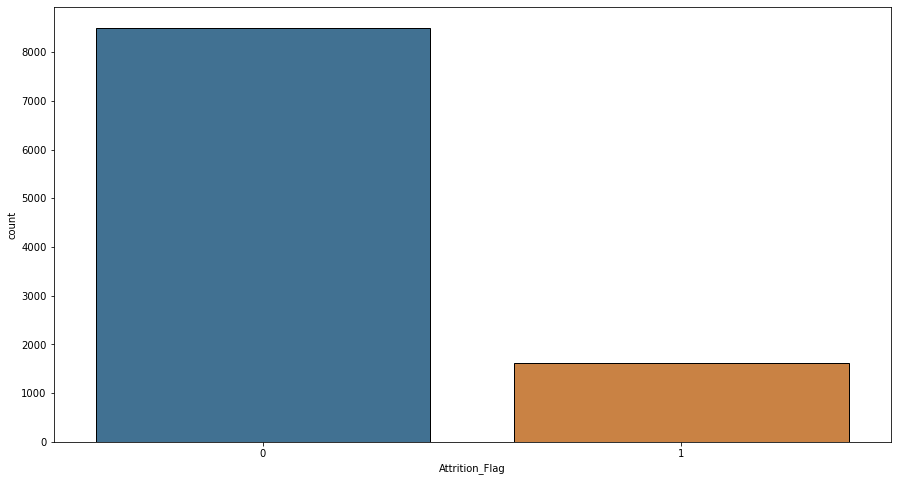

In [100]:
plt.figure(figsize = (15, 8))
sns.countplot(x = y, edgecolor = 'black', saturation = 0.55)
plt.show()

In [147]:
def plot_roc_auc_curve(X, y, model):
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=11
    )

    model.fit(x_train, y_train)
    y_predict = model.predict_proba(x_test)
    y_predict_proba = y_predict[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_predict_proba)

    plt.figure(figsize=(15, 8))
    plt.plot(fpr, tpr, "b+", linestyle="-")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.fill_between(fpr, tpr, alpha=0.5)
    auc_score = roc_auc_score(y_test, y_predict_proba)
    plt.title(f"ROC AUC Curve having \n AUC score : {auc_score}")

<IPython.core.display.Javascript object>

In [148]:
# funtion to plot learning curves


def plot_learning_curve(X, Y, model):

    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=11
    )
    train_loss, test_loss = [], []

    for m in range(100, len(x_train), 100):

        model.fit(x_train.iloc[:m, :], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m, :])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))

        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))

    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, "r-+", label="Training Loss")
    plt.plot(test_loss, "b-", label="Test Loss")
    plt.xlabel("Number Of Batches")
    plt.ylabel("Log-Loss")
    plt.legend(loc="best")

<IPython.core.display.Javascript object>

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Feature Engineering</h1><a id = "4" ></a>


**MISSING VALUE TREATMENT**


We will use KNN imputer to impute missing values.

KNNImputer: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.

KNN imputer replaces missing values using the average of k nearest non-missing feature values.  Nearest points are found based on euclidean distance.

The values obtained might not be integer always which is not be the best way to impute categorical values

To take care of that we will round off the obtained values to nearest integer value

In [66]:
df.isnull().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [67]:
# defining a list with names of columns that will be used for imputation
reqd_col_for_impute = ["Education_Level","Marital_Status"]

In [68]:
df[reqd_col_for_impute].head()

,Education_Level,Marital_Status
0,High School,Married
1,Graduate,Single
2,Graduate,Married
3,High School,NaN
4,Uneducated,Married


In [69]:
data1 = df.copy()

In [70]:
# we need to pass numerical values for each categorical column:
Marital_Status = {"Single": 0, "Married": 1, "Divorced": 2}
data1["Marital_Status"] = data1["Marital_Status"].map(Marital_Status)

Attrition_Flag = {"Existing Customer": 1, "Attrited Customer": 0}
data1["Attrition_Flag"] = data1["Attrition_Flag"].map(Attrition_Flag)

Education_Level = {"Uneducated": 0, "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5}
data1["Education_Level"] = data1["Education_Level"].map(Education_Level)

Gender = {"F": 0, "M": 1}
data1["Gender"] = data1["Gender"].map(Gender)

Card_Category = {"Blue": 0, "Silver": 1, "Gold": 2, "PLatinum": 3}
data1["Card_Category"] = data1["Card_Category"].map(Card_Category)

Income_Category = {"Less than $40K": 0,"$40K - $60K": 1, "$60K - $80K": 2, "$80K - $120K": 3, "$120K +": 4}
data1["Income_Category"] = data1["Income_Category"].map(Income_Category)



In [71]:
data1.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,1,45,1,3,1.0,1.0,2.0,0.0,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,1,49,0,5,3.0,0.0,0.0,0.0,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,1,51,1,3,3.0,1.0,3.0,0.0,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,1,40,0,4,1.0,NaN,0.0,0.0,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,1,40,1,3,0.0,1.0,2.0,0.0,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [72]:
for i in cat_col:
    print("Unique values in", i, "are :")
    print(df[i].value_counts())
    print("*" * 50)

Unique values in Attrition_Flag are :
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Gender are :
F    5358
M    4769
Name: Gender, dtype: int64
**************************************************
Unique values in Education_Level are :
Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
**************************************************
Unique values in Marital_Status are :
Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64
**************************************************
Unique values in Income_Category are :
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
**************************************************

In [73]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [74]:
for i in cat_col:
    print("Unique values in", i, "are :")
    print(data1[i].value_counts())
    print("*" * 50)

Unique values in Attrition_Flag are :
1    8500
0    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Gender are :
0    5358
1    4769
Name: Gender, dtype: int64
**************************************************
Unique values in Education_Level are :
3.0    3128
1.0    2013
0.0    1487
2.0    1013
4.0     516
5.0     451
Name: Education_Level, dtype: int64
**************************************************
Unique values in Marital_Status are :
1.0    4687
0.0    3943
2.0     748
Name: Marital_Status, dtype: int64
**************************************************
Unique values in Income_Category are :
0.0    3561
1.0    1790
3.0    1535
2.0    1402
4.0     727
Name: Income_Category, dtype: int64
**************************************************
Unique values in Card_Category are :
0.0    9436
1.0     555
2.0     116
Name: Card_Category, dtype: int64
**************************************************
Unique values in Dependent

In [75]:
# checking for missing values in the data
df.isnull().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [76]:
# checking for missing values in the data
data1.isnull().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                 20
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

**UNIVARIATE ANALYSIS**


**DATA PREPARATION FOR MODELING**


In [77]:
# X = data1.drop(['CLIENTNUM'], axis=1)
# y = data1["CLIENTNUM"].apply(lambda x: 1 if x == "yes" else 0)

In [78]:
# X = data1.drop(['Attrition_Flag'], axis=1)
# y = data1["Attrition_Flag"].apply(lambda x: 1 if x == "yes" else 0)

<h1 style="text-align: center;" class="list-group-item list-group-item-action active">Model</h1><a id = "6" ></a>

In [103]:
#Cross Validation Score

from sklearn.model_selection import StratifiedKFold

def compute_CV(X, y, model, k):
    
    kf = StratifiedKFold(n_splits = k)
    auc_scores = []
    i = 0
    
    for idx in kf.split(X = X, y = y):
        
        train_idx, val_idx = idx[0], idx[1]
        
        i += 1 
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_val)
        y_predict_prob = y_predict[:,1]
        
        auc_score = roc_auc_score(y_val, y_predict_prob)
        print(f'AUC Score of {i} Fold is : {auc_score}')
        auc_scores.append(auc_score)
    print('-----------------------------------------------')
    print(f'Average AUC Score of {k} Folds is : {np.mean(auc_scores)}')

In [109]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 19) (2026, 19) (2026, 19)


In [110]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 6075
Number of rows in validation data = 2026
Number of rows in test data = 2026


In [111]:
X.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [112]:
X.info

<bound method DataFrame.info of        Customer_Age  Gender  Dependent_count  Education_Level  Marital_Status  \
0                46       1                3              3.0               2   
1                52       0                1              1.0               1   
2                46       1                4              NaN               0   
3                51       0                3              0.0               2   
4                48       1                4              0.0               2   
...             ...     ...              ...              ...             ...   
10122            64       1                1              3.0               2   
10123            38       1                2              NaN               1   
10124            60       1                1              3.0               2   
10125            59       1                2              1.0               0   
10126            54       1                2              1.0               1

In [113]:
!pip install --upgrade IPython
%load_ext nb_black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 461.7 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: IPython
    Found existing installation: ipython 8.2.0
    Uninstalling ipython-8.2.0:
      Successfully uninstalled ipython-8.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


<IPython.core.display.Javascript object>

**CREATING LOGISTIC REGRESSION MODEL - MODEL NUMBER 1**


[[7.14963558e+08 0.00000000e+00 4.60000000e+01 ... 7.10000000e+01
  7.75000000e-01 0.00000000e+00]
 [7.10322033e+08 0.00000000e+00 5.20000000e+01 ... 7.70000000e+01
  9.25000000e-01 6.89000000e-01]
 [7.17849708e+08 0.00000000e+00 4.60000000e+01 ... 8.70000000e+01
  7.40000000e-01 5.13000000e-01]
 ...
 [7.11553308e+08 0.00000000e+00 6.00000000e+01 ... 8.80000000e+01
  8.33000000e-01 5.21000000e-01]
 [7.17624708e+08 1.00000000e+00 5.90000000e+01 ... 4.90000000e+01
  6.90000000e-01 0.00000000e+00]
 [7.21350783e+08 0.00000000e+00 5.40000000e+01 ... 3.90000000e+01
  7.73000000e-01 3.54000000e-01]]


<IPython.core.display.Javascript object>

In [126]:
# Logistic Regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

std = StandardScaler()

data1 = std.fit_transform(X)

X_std = pd.DataFrame(data1, columns=X.columns)

clf1 = LogisticRegression()

compute_CV(X_std, y, clf1, 5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>

In [114]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction

from sklearn.linear_model import LogisticRegression

# To get diferent metric scores

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

<IPython.core.display.Javascript object>

In [115]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn_with_threshold(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [116]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

In [117]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data

model = LogisticRegression(solver="newton-cg", random_state=1)
lg = model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>

In [94]:
log_odds = lg.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=["coef"]).T

NameError: ignored

<IPython.core.display.Javascript object>

In [ ]:
# converting coefficients to odds
odds = np.exp(lg.coef_[0])

# finding the percentage change
perc_change_odds = (np.exp(lg.coef_[0]) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns

SyntaxError: ignored

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

NameError: ignored

In [ ]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

NameError: ignored

In [ ]:
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

NameError: ignored

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)


NameError: ignored

In [ ]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

NameError: ignored

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

NameError: ignored

Let's use precision recall curve and see if we can find a better threshold.

In [ ]:
y_scores = lg.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

NameError: ignored

In [ ]:
# setting the threshold
optimal_threshold_curve = 0.34

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

NameError: ignored

In [ ]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

NameError: ignored

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.33 Threshold",
    "Logistic Regression-0.37 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

NameError: ignored

**CREATING DECISION TREE MODEL - MODEL NUMBER 2**


In [95]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# To tune different models
from sklearn.model_selection import GridSearchCV


# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [96]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn_with_threshold(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [97]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [98]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

In [99]:
model = DecisionTreeClassifier(criterion="gini", random_state=1)
model.fit(X_train, y_train)

ValueError: ignored

<IPython.core.display.Javascript object>

In [100]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

In [101]:
model = DecisionTreeClassifier(criterion="gini", random_state=1)
model.fit(X_train, y_train)

ValueError: ignored

<IPython.core.display.Javascript object>

In [ ]:
confusion_matrix_sklearn(model, X_train, y_train)

ValueError: ignored

In [ ]:
decision_tree_perf_train = model_performance_classification_sklearn(
    model, X_train, y_train
)
decision_tree_perf_train

ValueError: ignored

In [ ]:
feature_names = list(X_train.columns)
print(feature_names)

['CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [ ]:
plt.figure(figsize=(20, 30))
out = tree.plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

NameError: ignored

<Figure size 1440x2160 with 0 Axes>

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model, feature_names=feature_names, show_weights=True))

NameError: ignored

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)

SyntaxError: ignored

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

AttributeError: ignored

Model improvement with Pre-pruning.

In [ ]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(6, 15),
    "min_samples_leaf": [1, 2, 5, 7, 10],
    "max_leaf_nodes": [2, 3, 5, 10],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

NameError: ignored

In [ ]:
confusion_matrix_sklearn(estimator, X_train, y_train)

NameError: ignored

In [ ]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(
    estimator, X_train, y_train
)
decision_tree_tune_perf_train

NameError: ignored

In [ ]:
plt.figure(figsize=(10, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

NameError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        model.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

AttributeError: ignored

In [ ]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

NameError: ignored

Cost complexity pruning

In [ ]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


NameError: ignored

In [ ]:
pd.DataFrame(path)

NameError: ignored

NameError: ignored

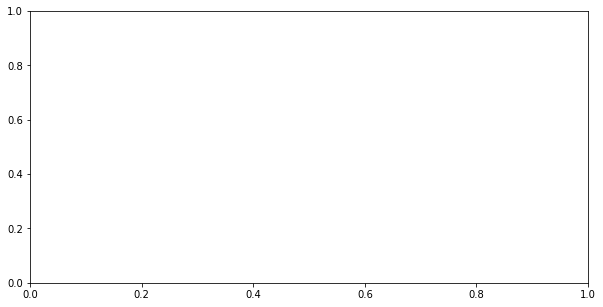

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

NameError: ignored

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

NameError: ignored

In [ ]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

NameError: ignored

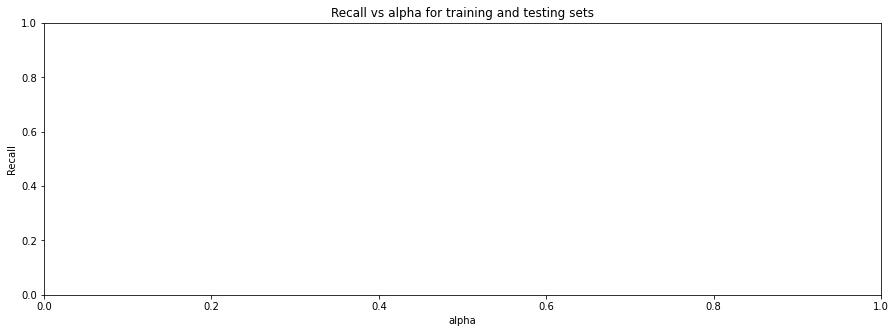

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

ValueError: ignored

In [ ]:
confusion_matrix_sklearn(model, X_test, y_test)

ValueError: ignored

In [ ]:
decision_tree_perf_test = model_performance_classification_sklearn(
    model, X_test, y_test
)
decision_tree_perf_test

ValueError: ignored

In [ ]:
confusion_matrix_sklearn(estimator, X_test, y_test)

NameError: ignored

In [ ]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(
    estimator, X_test, y_test
)
decision_tree_tune_perf_test

NameError: ignored

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [decision_tree_perf_train.T, decision_tree_tune_perf_train.T], axis=1,
)
models_train_comp_df.columns = ["Decision Tree sklearn", "Decision Tree (Pre-Pruning)"]
print("Training performance comparison:")
models_train_comp_df

NameError: ignored

In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [decision_tree_perf_test.T, decision_tree_tune_perf_test.T], axis=1,
)
models_test_comp_df.columns = ["Decision Tree sklearn", "Decision Tree (Pre-Pruning)"]
print("Test set performance comparison:")
models_test_comp_df

NameError: ignored

**Model Building on Oversampled Data on all 6 Models**



**Model Building on Undersampled Data on all 6 Models**


**Tuning at least 3 models out of the 18 models created above.  Select 3 out of 18 that will perform best after tuning.  Tune using randomized search and metric of interest.  Check the performance of 3 tuned models.**


**CREATING PIPELINE TO PRODUCTIONIZE THE BEST MODEL OF THE 3 TUNED ABOVE**



In [ ]:
# separating data into X and Y
X = df.drop([''], axis = 1)
Y = df['']

KeyError: ignored

In [ ]:
# dividing data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1, stratify = Y)

NameError: ignored

In [ ]:
# pipeline takes a list of tuples as parameter. The last entry is the call to the modeling algorithm
pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', LogisticRegression())
])

# "scaler" is the name assigned to StandardScaler
# "clf" is the name assigned to LogisticRegression

In [ ]:
# Any element of the pipeline can be called later using the assigned name
pipeline['scaler'].fit(X_train)

NameError: ignored

In [ ]:
# now the pipeline object can be used as a normal classifier
pipeline.fit(X_train,Y_train)

NameError: ignored

In [ ]:
# pipeline object's accuracy on the train set
pipeline.score(X_train, Y_train)

NameError: ignored

In [ ]:
# pipeline object's accuracy on the test set
pipeline.score(X_test, Y_test)

NameError: ignored

**make_pipeline**  make_pipeline is an extended version of the pipeline. Here, we don't need to assign names separately to each element of the pipeline.


In [ ]:
# defining pipe using make_pipeline
pipe = make_pipeline(StandardScaler(), (LogisticRegression())) 

In [ ]:
# we can see that make_pipeline itself assigned names to all the objects
pipe.steps

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression())]

In [ ]:
# now you can use the pipe object as a normal classifier
pipe.fit(X_train,Y_train)

NameError: ignored

In [ ]:
# pipe object's accuracy on the train set
pipe.score(X_train, Y_train)

NameError: ignored

In [ ]:
# pipe object's accuracy on the test set
pipe.score(X_test, Y_test)

NameError: ignored

**HYPERPARAMETER TUNING WITH GRIDSEARCHCV AND RANDOMIZEDSEARCHCV**


In [ ]:
# checking missing values in the data
df.isna().sum()

NameError: ignored

In [ ]:
data[""] = data[""].astype("category")
data[""] = data[""].astype("category")
data[""] = data[""].astype("category")

NameError: ignored

In [ ]:
# checking the distribution of the target variable
data["target"].value_counts(1)

NameError: ignored

In [ ]:
# separating the independent and dependent variables
X = data.drop(["target"], axis=1)
y = data["target"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

NameError: ignored

In [ ]:
# Splitting data into training, validation and test set:

# first we split data into 2 parts, say temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5, stratify=y
)

# then we split the temporary set into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=5, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)

NameError: ignored

In [ ]:
# Let's impute the missing values
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")

# fit the imputer on train data and transform the train data
X_train["  "] = imp_median.fit_transform(X_train[["   "]])

# transform the validation and test data using the imputer fit on train data
X_val["  "] = imp_median.transform(X_val[["  "]])
X_test["  "] = imp_median.transform(X_test[["   "]])

NameError: ignored

In [ ]:
# Checking class balance for whole data, train set, validation set, and test set

print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_val")
print(y_val.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y


NameError: ignored

Model evaluation criterion
What does a bank want?

A bank wants to minimize the loss - it can face 2 types of losses here:
Whenever a bank lends money to a customer, they don't return it.
A bank doesn't lend money to a customer thinking a customer will default but in reality, the customer won't - opportunity loss.
Which loss is greater ?

Lending to a customer who wouldn't be able to pay back.
Since we want to reduce loan defaults we should use Recall as a metric of model evaluation instead of accuracy.

Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a bad customer as a good customer.

LET'S BUILD A MODEL WITH DEFAULT PARAMETERS AND SEE ITS PERFORMANCE

In [ ]:
# model without hyperparameter tuning
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

NameError: ignored

In [ ]:
# Checking recall score on train and validation set
print("Recall on train and validation set")
print(recall_score(y_train, rf.predict(X_train)))
print(recall_score(y_val, rf.predict(X_val)))
print("")

# Checking Precision score on train and validation set
print("Precision on train and validation set")
print(precision_score(y_train, rf.predict(X_train)))
print(precision_score(y_val, rf.predict(X_val)))

print("")

# Checking Accuracy score on train and validation set
print("Accuracy on train and validation set")
print(accuracy_score(y_train, rf.predict(X_train)))
print(accuracy_score(y_val, rf.predict(X_val)))

Recall on train and validation set


NameError: ignored

The model is performing well on training data but performance on validate data is not good.  Let's see if we can improve it with hyperparameter tuning.

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
print(np.arange(0.2, 0.7, 0.1))

print(np.arange(5,10))

[0.2 0.3 0.4 0.5 0.6]
[5 6 7 8 9]


In [ ]:
%%time

# Choose the type of classifier. 
rf1 = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "class_weight" : ['balanced', 'balanced_subsample'],
    "max_depth":np.arange(3,4,5),
    "min_impurity_decrease":[0.001, 0.002, 0.003]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf1, parameters, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search

grid_obj = grid_obj.fit(X_train, y_train)

# Print the best combination of parameters
grid_obj.best_params_

NameError: ignored

In [ ]:
grid_obj.best_score_

AttributeError: ignored

In [ ]:
# Set the clf to the best combination of parameters
rf1_tuned = RandomForestClassifier(
    class_weight="balanced",
    max_features=0.2,
    max_samples=0.6000000000000001,
    min_samples_leaf=5,
    n_estimators=150,
    max_depth=3,
    random_state=1,
    min_impurity_decrease=0.001,
)

# Fit the best algorithm to the data.
rf1_tuned.fit(X_train, y_train)

NameError: ignored

In [ ]:
# Checking recall score on train and validation set
print("Recall on train and validation set")
print(recall_score(y_train, rf1_tuned.predict(X_train)))
print(recall_score(y_val, rf1_tuned.predict(X_val)))
print("")

# Checking precision score on train and validation set
print("Precision on train and validation set")
print(precision_score(y_train, rf1_tuned.predict(X_train)))
print(precision_score(y_val, rf1_tuned.predict(X_val)))
print("")

# Checking accuracy score on train and validation set
print("Accuracy on train and validation set")
print(accuracy_score(y_train, rf1_tuned.predict(X_train)))
print(accuracy_score(y_val, rf1_tuned.predict(X_val)))

Recall on train and validation set


NameError: ignored

RANDOMIZED SEARCH CV


In [ ]:
%%time

# Choose the type of classifier. 
rf2 = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1), 
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "max_depth":np.arange(3,4,5),
    "class_weight" : ['balanced', 'balanced_subsample'],
    "min_impurity_decrease":[0.001, 0.002, 0.003]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the random search
grid_obj = RandomizedSearchCV(rf2, parameters,n_iter=30, scoring=acc_scorer,cv=5, random_state = 1, n_jobs = -1, verbose = 2)
# using n_iter = 30, so randomized search will try 30 different combinations of hyperparameters
# by default, n_iter = 10

grid_obj = grid_obj.fit(X_train, y_train)

# Print the best combination of parameters
grid_obj.best_params_

NameError: ignored

In [ ]:
grid_obj.best_score_

AttributeError: ignored

In [ ]:
# Set the clf to the best combination of parameters
rf2_tuned = RandomForestClassifier(
    class_weight="balanced",
    max_features=0.2,
    max_samples=0.5,
    min_samples_leaf=5,
    n_estimators=150,
    random_state=1,
    max_depth=3,
    min_impurity_decrease=0.003,
)

# Fit the best algorithm to the data.
rf2_tuned.fit(X_train, y_train)

NameError: ignored

In [ ]:
# Checking recall score on train and validation set
print("Recall on train and validation set")
print(recall_score(y_train, rf2_tuned.predict(X_train)))
print(recall_score(y_val, rf2_tuned.predict(X_val)))
print("")
print("Precision on train and validation set")
# Checking precision score on train and validation set
print(precision_score(y_train, rf2_tuned.predict(X_train)))
print(precision_score(y_val, rf2_tuned.predict(X_val)))
print("")
print("Accuracy on train and validation set")
# Checking accuracy score on train and validation set
print(accuracy_score(y_train, rf2_tuned.predict(X_train)))
print(accuracy_score(y_val, rf2_tuned.predict(X_val)))

Recall on train and validation set


NameError: ignored

In [ ]:
model = rf1_tuned

In [ ]:
# Checking recall score on test set
print("Recall on test set")
print(recall_score(y_test, model.predict(X_test)))
print("")

# Checking precision score on test set
print("Precision on test set")
print(precision_score(y_test, model.predict(X_test)))
print("")

# Checking accuracy score on test set
print("Accuracy on test set")
print(accuracy_score(y_test, model.predict(X_test)))

Recall on test set


NameError: ignored

**CREATING MODEL WITH BAGGING AND RANDOM FOREST- MODEL NUMBER 3, 4**


In [ ]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator, X_test, y_test)

In [ ]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print("Training performance:\n",bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print("Testing performance:\n",bagging_classifier_model_test_perf)
#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier, X_test, y_test)

In [ ]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.35,1:0.65},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,10), 
              'min_samples_leaf': [5, 7, 10, 15],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

In [ ]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)
#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator, X_test, y_test)

In [ ]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.35,1:0.65},random_state=1)

parameters = {  
                'max_depth': list(np.arange(3,10,1)),
                'max_features': np.arange(0.6,1.1,0.1),
                'max_samples': np.arange(0.7,1.1,0.1),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(30,160,20),
                'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

In [ ]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned, X_test, y_test)

In [ ]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

In [ ]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print("Training performance:\n",bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print("Testing performance:\n",bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned, X_test, y_test)

**COMPARING BAGGING AND RANDOM FOREST MODELS**


In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned"]
print("Training performance comparison:")
models_train_comp_df

In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T, bagging_estimator_tuned_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned"]
print("Testing performance comparison:")
models_test_comp_df

**CREATING MODEL WITH BOOSTING - MODEL NUMBER 5, 6, 7 (AdaBoost Classifier, Gradient Boosting Classifier, and XGBoost Classifier)**


We are going to build 3 ensemble models here - AdaBoost Classifier, Gradient Boosting Classifier and XGBoost Classifier.
First, let's build these models with default parameters and then use hyperparameter tuning to optimize the model performance.
We will calculate all three metrics - Accuracy, Precision and Recall but the metric of interest here is recall.
Recall - It gives the ratio of True positives to Actual positives, so high Recall implies low false negatives, i.e. low chances of predicting a defaulter as non defaulter 



In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
#To install xgboost library use - !pip install xgboost 
from xgboost import XGBClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

In [ ]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    

In [ ]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

ValueError: ignored

In [ ]:
AdaBoostClassifier(random_state=1)

AdaBoostClassifier(random_state=1)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

ValueError: ignored

In [ ]:
make_confusion_matrix(abc,y_test)

ValueError: ignored

In [ ]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

ValueError: ignored

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score=get_metrics_score(gbc)

ValueError: ignored

In [ ]:
make_confusion_matrix(gbc,y_test)

ValueError: ignored

In [ ]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(eval_metric='logloss', random_state=1)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  1.0
Accuracy on test set :  1.0
Recall on training set :  0.0
Recall on test set :  0.0
Precision on training set :  0.0
Precision on test set :  0.0


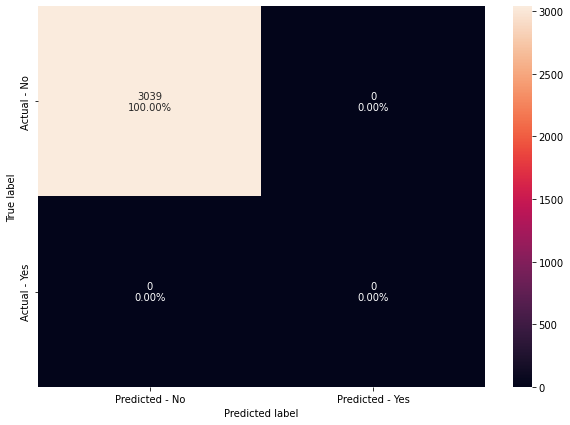

In [ ]:
make_confusion_matrix(xgb,y_test)

**COMPARE THE RESUTLS OF ADABOOST, GRADIENT BOOST, AND XGBOOST CLASSIFIERS.**


**HYPERPARAMETER TUNING FOR ADABOOST, GRADIENT BOOST, AND XGBOOST CLASSIFIERS**


AdaBoost Classifier

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.
Some important hyperparamters are:
base_estimator: The base estimator from which the boosted ensemble is built. By default the base estimator is a decision tree with max_depth=1
n_estimators: The maximum number of estimators at which boosting is terminated. Default value is 50.
learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.

In [ ]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

NotFittedError: ignored

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_tuned_score=get_metrics_score(abc_tuned)

NotFittedError: ignored

In [ ]:
make_confusion_matrix(abc_tuned,y_test)

NotFittedError: ignored

INSIGHTS:

In [ ]:
importances = abc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: ignored

Gradient Boosting Classifier

Most of the hyperparameters available are same as random forest classifier.
init: An estimator object that is used to compute the initial predictions. If ‘zero’, the initial raw predictions are set to zero. By default, a DummyEstimator predicting the classes priors is used.
There is no class_weights parameter in gradient boosting.

In [ ]:
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
gbc_init.fit(X_train,y_train)

ValueError: ignored

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_init_score=get_metrics_score(gbc_init)

ValueError: ignored

In [ ]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

NotFittedError: ignored

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_tuned_score=get_metrics_score(gbc_tuned)

ValueError: ignored

In [ ]:
make_confusion_matrix(gbc_tuned,y_test)

ValueError: ignored

INSIGHTS:

In [ ]:
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NotFittedError: ignored

XGBoost Classifier

XGBoost has many hyper parameters which can be tuned to increase the model performance. You can read about them in the xgboost documentation here. Some of the important parameters are:

scale_pos_weight:Control the balance of positive and negative weights, useful for unbalanced classes. It has range from 0 to ∞.
subsample: Corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
colsample_bytree: Corresponds to the fraction of features (the columns) to use.
colsample_bylevel: The subsample ratio of columns for each level. Columns are subsampled from the set of columns chosen for the current tree.
colsample_bynode: The subsample ratio of columns for each node (split). Columns are subsampled from the set of columns chosen for the current level.
max_depth: is the maximum number of nodes allowed from the root to the farthest leaf of a tree.
learning_rate/eta: Makes the model more robust by shrinking the weights on each step.
gamma: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.

In [ ]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.5,
              eval_metric='logloss', learning_rate=0.01, n_estimators=10,
              random_state=1, scale_pos_weight=0, subsample=0.5)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_tuned_score=get_metrics_score(xgb_tuned)

Accuracy on training set :  1.0
Accuracy on test set :  1.0
Recall on training set :  0.0
Recall on test set :  0.0
Precision on training set :  0.0
Precision on test set :  0.0


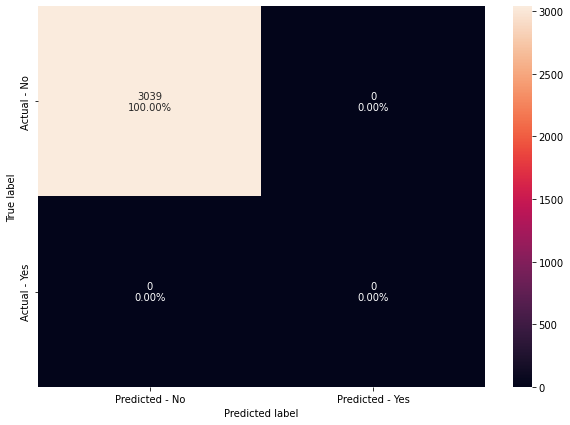

In [ ]:
make_confusion_matrix(xgb_tuned,y_test)


INSIGHTS:

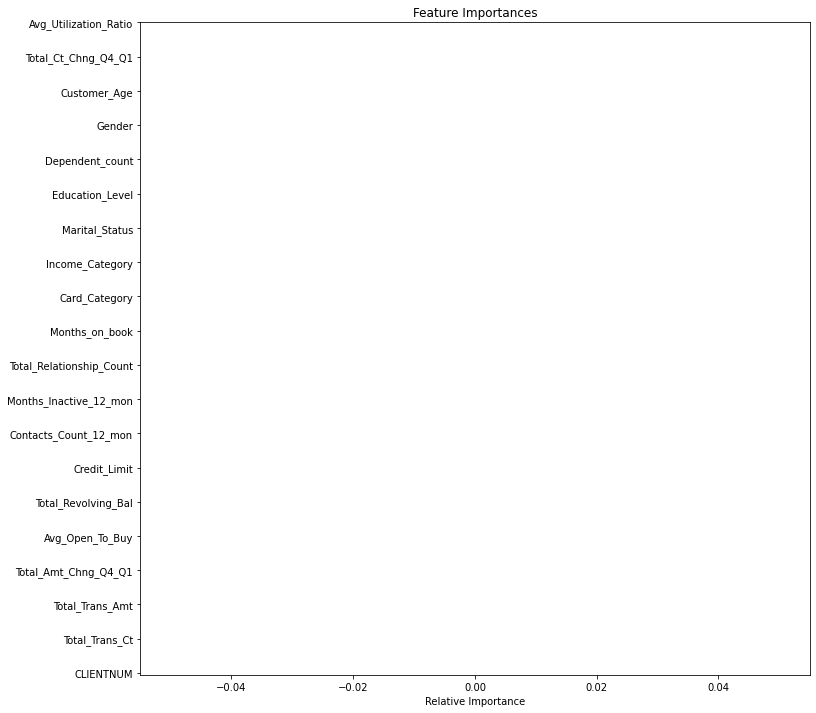

In [ ]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**COMPARING THE THREE BOOST MODELS:**


In [ ]:
# defining list of models
models = [abc, abc_tuned, gbc, gbc_init, gbc_tuned, xgb, xgb_tuned]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

ValueError: ignored

In [ ]:
comparison_frame = pd.DataFrame({'Model':['AdaBoost with default paramters','AdaBoost Tuned', 
                                          'Gradient Boosting with default parameters','Gradient Boosting with init=AdaBoost',
                                          'Gradient Boosting Tuned','XGBoost with default parameters','XGBoost Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame